<a href="https://colab.research.google.com/github/ThanujSingaravelan/master_thesis_battery_uncertainty/blob/main/thesis_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clone github repo and Import dependencies**

In [ ]:
!git clone https://github.com/ThanujSingaravelan/master_thesis_battery_uncertainty.git
%cd master_thesis_battery_uncertainty 

In [87]:
import time
import numpy as np
import pandas as pd
import scipy
import copy
from matplotlib import pyplot as plt
from keras.utils.layer_utils import count_params

import uncertainty_modelling_core


# **Import Dataset and Preprocess**

1. You experiment with different train and test datatsets splits.

2. You can also add different anomalies to the test datasets to check the preidction result later.

3. You can select choose to use differenet models (each model has its own representative string):

  1. One-stage models ( two_stage = False )
  * GMLR ----------------------> "MLR"
  * DNN -----------------------> "DNN"
  * RNN -----------------------> "CNN"
  * Multi Head ----------------> "MultiHead"

  2. Two-Stage Models ( two_stage = True )
  * Linear R, Dynmaic OCV -----> "LinRDynOCV"
  * GECNN ---------------------> "PhysicsEnsemble"
  * Dual Channel RNN ----------> "DualChannelRNNHead"
  * Dual Channel CNN ----------> "DualChannelCNNHead"
  * Dual Channel Multi Head ---> "DualChannelMultiHead"

4. You can define different numebr of epochs, window size and stride size

> Tip: The  ***{x}*** - symbol on the left side has a list of all variables stored in memory.


In [84]:
df_BNN = pd.read_csv('demo_data_BNN_model.csv', index_col=False)
uncertain_data = uncertainty_modelling_core.UncertaintyData()



### Define training set ###
df_train = copy.deepcopy(df_BNN[0:20000])

### Define test sets ###
df_test_1 = copy.deepcopy(df_BNN[15000:20000])
df_test_2 = copy.deepcopy(df_BNN[20000:25000])

### Add artificial anomalies to any series ###
df_test_2.loc[20000:21000,'soc'] = 0.0 

### Choose desired model to experiment ###
model_name = "MLR"
two_stage = False

### You can define differnt number of epochs ###
epochs_1 = 200
epochs_2 = 200

### You can also choose stride and window size for preprocessing ###
stride = 1
window_size = 10


uncertain_data.add_data(df_train)
uncertain_data.compute_tensors_windowed(stride=stride, window_size=window_size, clustering_mode=False)
training_data = uncertain_data.get_tensor_data()

# **Train the Model**

In [ ]:
Class = getattr(uncertainty_modelling_core, model_name)
model = Class()

model.add_tensor_data(training_data)

m = model.create_core()


start = time.time()
    
model.training_parameters['epochs'] = epochs_1
model.fit_model(model_name=model_name)

if two_stage:
  model.training_parameters['epochs'] = epochs_2
  m = model.update_model(probabilstic_mode=True)
  model.fit_model(model_name=model_name)

stop = time.time()
train_time = stop - start


params = count_params(m.weights)
        

# **Plot the Outputs of the Models on test dataset**

Select which test data to ealuate

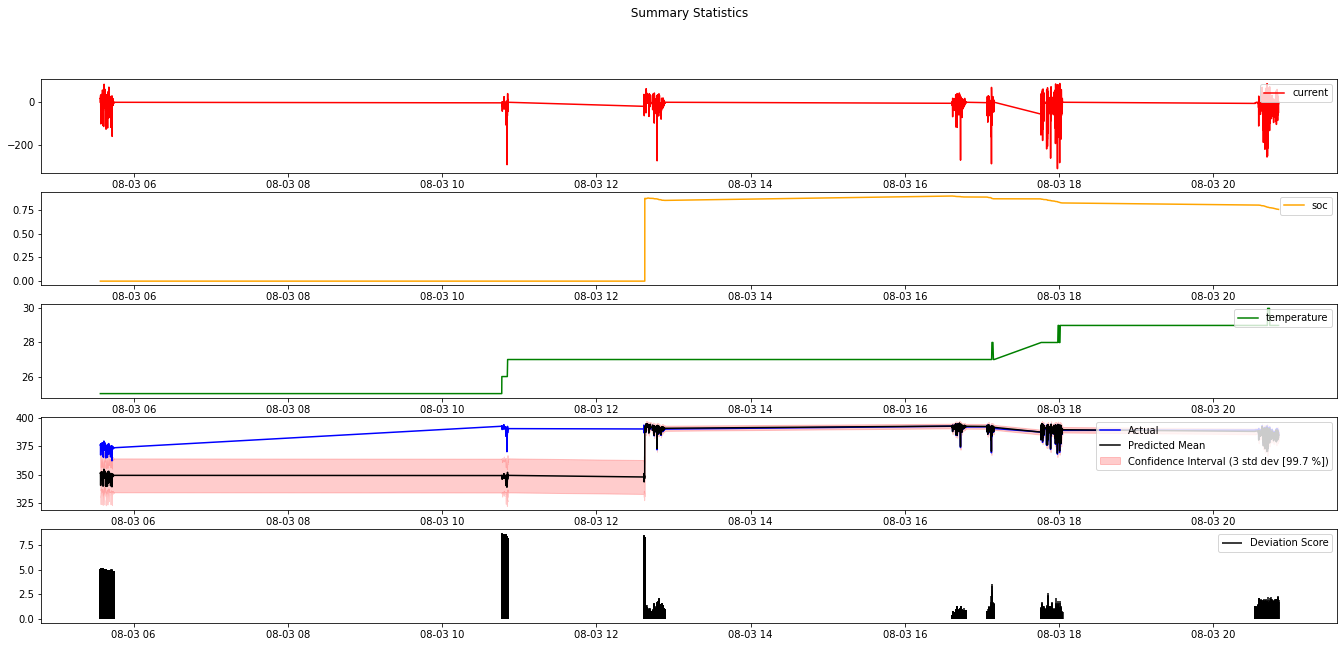

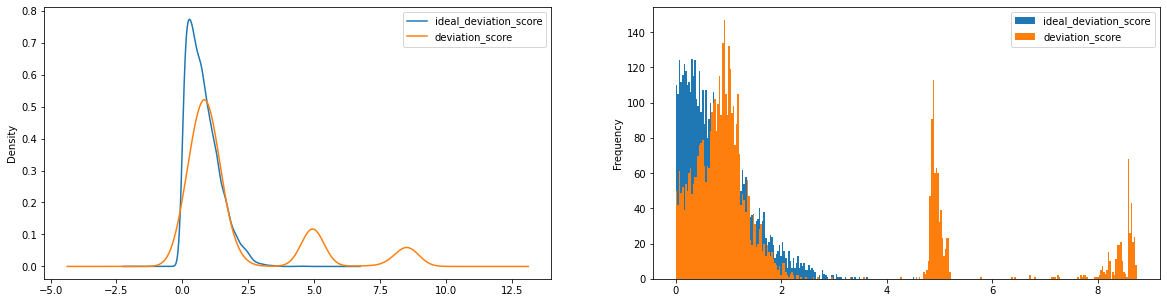

In [78]:
test_data = df_test_2


predicted_data = model.predict_on_data(df_test_2, model_name=model_name)

fig1 = model.plot_summary()
fig1.set_size_inches(20,10)

fig2 = plt.figure()
ax1 = fig2.add_subplot(121)
predicted_data.plot.density(y=["ideal_deviation_score", "deviation_score"], ax=ax1)
ax2 = fig2.add_subplot(122)
predicted_data.plot.hist(y=["ideal_deviation_score", "deviation_score"], bins=300, ax=ax2)

#fig2.suptitle("KL Divergence of [Deviation Score -> N(0,1)] : " + str(np.round(KL_div_DS,2)))
fig2.set_size_inches(20,5)
print


# **Calcuate Summary Metrics for the data on test dataset**

In [106]:
result_df = pd.DataFrame(columns=['min_DS','max_DS','mean_DS',
                                  'stddev_DS','z_score_max_DS','quantile_1_DS','quantile_25_DS','quantile_50_DS',
                                  'quantile_75_DS','quantile_99_DS','inter_quantile_range','lower_fence','upper_fence',
                                  'mod_z_score_max_DS','KL_div_DS','mean_model_stddev'])

min_DS = predicted_data['deviation_score'].min()
max_DS = predicted_data['deviation_score'].max()
mean_DS = predicted_data['deviation_score'].mean()
stddev_DS = predicted_data['deviation_score'].std()
z_score_max_DS = (max_DS - mean_DS) / stddev_DS
quantile_1_DS = predicted_data['deviation_score'].quantile(0.01)
quantile_25_DS = predicted_data['deviation_score'].quantile(0.25)
quantile_50_DS = predicted_data['deviation_score'].quantile(0.50)
quantile_75_DS = predicted_data['deviation_score'].quantile(0.75)
quantile_99_DS = predicted_data['deviation_score'].quantile(0.99)
inter_quantile_range = quantile_75_DS - quantile_25_DS
lower_fence = quantile_25_DS - 1.5*inter_quantile_range
upper_fence = quantile_75_DS + 1.5*inter_quantile_range
mod_z_score_max_DS = (max_DS - quantile_50_DS) / inter_quantile_range

KL_div_DS =  np.nanmean(scipy.special.kl_div(
        predicted_data['ideal_deviation_score'].to_numpy(),
        predicted_data['deviation_score'].to_numpy()))

mean_model_stddev = predicted_data['stddev'].mean()

result_df = pd.concat([result_df,
                        pd.DataFrame([[min_DS,
                                      max_DS,
                                      mean_DS,
                                      stddev_DS,
                                      z_score_max_DS,
                                      quantile_1_DS,
                                      quantile_25_DS,
                                      quantile_50_DS,
                                      quantile_75_DS,
                                      quantile_99_DS,
                                      inter_quantile_range,
                                      lower_fence,
                                      upper_fence,
                                      mod_z_score_max_DS,
                                      KL_div_DS,
                                      mean_model_stddev]], columns=result_df.columns)], 
                      ignore_index=True)

print(result_df)

     min_DS    max_DS   mean_DS  stddev_DS  z_score_max_DS  quantile_1_DS  \
0  0.000527  8.746464  1.909417   2.301753        2.970365       0.031123   

   quantile_25_DS  quantile_50_DS  quantile_75_DS  quantile_99_DS  \
0        0.622495        0.978437        1.577926        8.661362   

   inter_quantile_range  lower_fence  upper_fence  mod_z_score_max_DS  \
0              0.955431    -0.810651     3.011072            8.130394   

   KL_div_DS  mean_model_stddev  
0   1.128969           1.623871  
